### Importing Libraries

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!unzip "/content/drive/MyDrive/Ara Proje/archive.zip" -d "/content/fer"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/fer/train/sad/Training_65329617.jpg  
  inflating: /content/fer/train/sad/Training_65338712.jpg  
  inflating: /content/fer/train/sad/Training_65338797.jpg  
  inflating: /content/fer/train/sad/Training_65387162.jpg  
  inflating: /content/fer/train/sad/Training_65404494.jpg  
  inflating: /content/fer/train/sad/Training_65426218.jpg  
  inflating: /content/fer/train/sad/Training_65430136.jpg  
  inflating: /content/fer/train/sad/Training_65437377.jpg  
  inflating: /content/fer/train/sad/Training_6545735.jpg  
  inflating: /content/fer/train/sad/Training_65463385.jpg  
  inflating: /content/fer/train/sad/Training_65473985.jpg  
  inflating: /content/fer/train/sad/Training_65502829.jpg  
  inflating: /content/fer/train/sad/Training_65505359.jpg  
  inflating: /content/fer/train/sad/Training_65508578.jpg  
  inflating: /content/fer/train/sad/Training_65516023.jpg  
  inflating: /content/fer/train/sad/Training_65524027.

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.preprocessing import image
import glob
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, Input, Dense, Flatten, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import resnet50, vgg16 

### Exploring Dataset

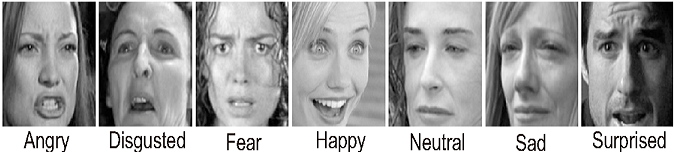

FER-2013 veri seti 35.887 tane etiketli yüz görselinden oluşmaktadır. Bu verilerin 28709'u eğitim için ayrılmışken 7178'i ise test için ayrılmıştır. FER veri setindeki görseller 48x48 boyutuna sahip gri-seviye görsellerdir. Bu veri setindeki ifadeler 7 duygu durumundan biriyle etiketlenmişlerdir. Bunlar angry(kızgın), disgusted(iğrenme), fear(korku), happy(mutlu), neutral(nötr), sad(üzgün) ve surprised(şaşkın) şeklindedir. 

In [ ]:
train_data_path = "/content/fer/train" 
test_data_path =  "/content/fer/test"


print("Veri setindeki sınıflar:")
for i in os.listdir(train_data_path):
    print(i)

Veri setindeki sınıflar:
disgust
neutral
fear
happy
sad
angry
surprise


In [ ]:
def number_of_expressions_in_each_class(data_path):
    
    exp_dict = {}
    number_of_images=0
    
    for exp in os.listdir(data_path):
        full_path = os.path.join(data_path, exp)
        exp_dict[exp] = len(os.listdir(full_path))
        number_of_images += len(os.listdir(full_path))
        
    return number_of_images, exp_dict      
        
number_of_train_images, train_dict = number_of_expressions_in_each_class(train_data_path)
number_of_test_images, test_dict = number_of_expressions_in_each_class(test_data_path)

df_train = pd.DataFrame(train_dict, index = ["train_seti"])
df_test = pd.DataFrame(test_dict, index = ["test_seti"])

print(df_train, "\n")
print(df_test)

            disgust  neutral  fear  happy   sad  angry  surprise
train_seti      436     4965  4097   7215  4830   3995      3171 

           disgust  neutral  fear  happy   sad  angry  surprise
test_seti      111     1233  1024   1774  1247    958       831


In [ ]:
print(f"Toplam eğitim seti: {number_of_train_images}")
print(f"Toplam test seti: {number_of_test_images}")

Toplam eğitim seti: 28709
Toplam test seti: 7178


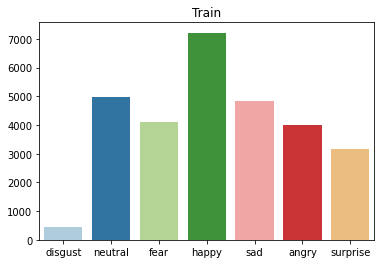

In [ ]:
sns.barplot(data = df_train, palette="Paired");
plt.title("Train");

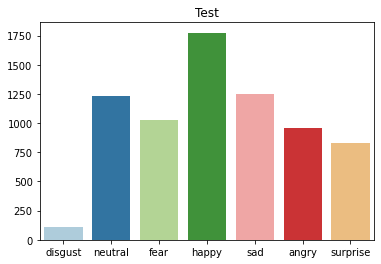

In [ ]:
sns.barplot(data = df_test, palette="Paired");
plt.title("Test");

TRAIN


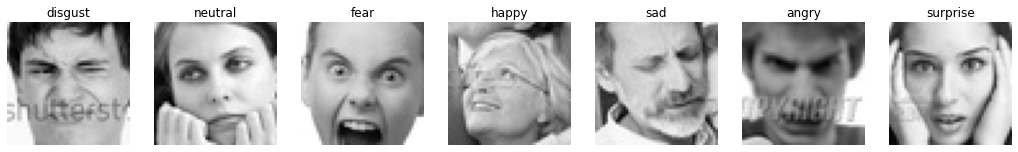

In [ ]:
# Veri setinden bazı örneklere bakalım.
def plot_some_images(train_data_path):
    plt.figure(figsize=(18,22))

    i=1
    j=7
    k=1
    image_size=(48,48)

    for exp in os.listdir(train_data_path):
        full_path = os.path.join(train_data_path, exp)
        images_path = glob.glob(os.path.join(full_path, '*.jpg'))
        random_image_name = random.choice(images_path)
        #print(random_image_name)
        img = image.load_img(random_image_name, target_size=image_size, color_mode="grayscale")

        plt.subplot(i,j,k)
        k+=1
        plt.imshow(img, cmap="gray")
        plt.title(exp)
        plt.axis("off")
        
print("TRAIN")
plot_some_images(train_data_path)

### Creating Generator

In [ ]:
def create_generator(batch_size, train_data_path, test_data_path):
    
    target_size=(48,48)
    
    train_preprocesser = ImageDataGenerator(
        rescale = 1/255.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        validation_split=0.2
    )
    
    train_generator = train_preprocesser.flow_from_directory(
        train_data_path,
        class_mode = "categorical",
        color_mode = "grayscale",
        target_size = target_size,
        shuffle = True,
        batch_size = batch_size,
        subset = "training"
    )
    
    val_generator = train_preprocesser.flow_from_directory(
        train_data_path,
        class_mode = "categorical",
        color_mode = "grayscale",
        target_size = target_size,
        shuffle = True,
        batch_size = batch_size,
        subset = "validation"
    )
    
    test_preprocesser = ImageDataGenerator(rescale=1./255,
                                           width_shift_range=0.1,
                                           height_shift_range=0.1,
                                           horizontal_flip=True)
    
    test_generator = test_preprocesser.flow_from_directory(
        test_data_path,
        class_mode = "categorical",
        color_mode = "grayscale",
        target_size=target_size,
        shuffle = False,
        batch_size = batch_size
    )
    
    return train_generator, val_generator, test_generator

In [ ]:
batch_size = 64

train_generator, val_generator, test_generator = create_generator(batch_size, train_data_path, test_data_path)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

### Building Models

#### My CNN Model

In [ ]:
def CNN_model(number_of_classes):
    
    model = models.Sequential()
    
    model.add(Conv2D(32, (3,3), padding="same", activation="relu", input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.3))
    
    model.add(Conv2D(512, (3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(Conv2D(1024, (3,3), padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D())
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(512, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    
    model.add(Dense(number_of_classes, activation="softmax"))
    
    return model

In [ ]:
number_of_classes = train_generator.num_classes
model_1 = CNN_model(number_of_classes)
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                        

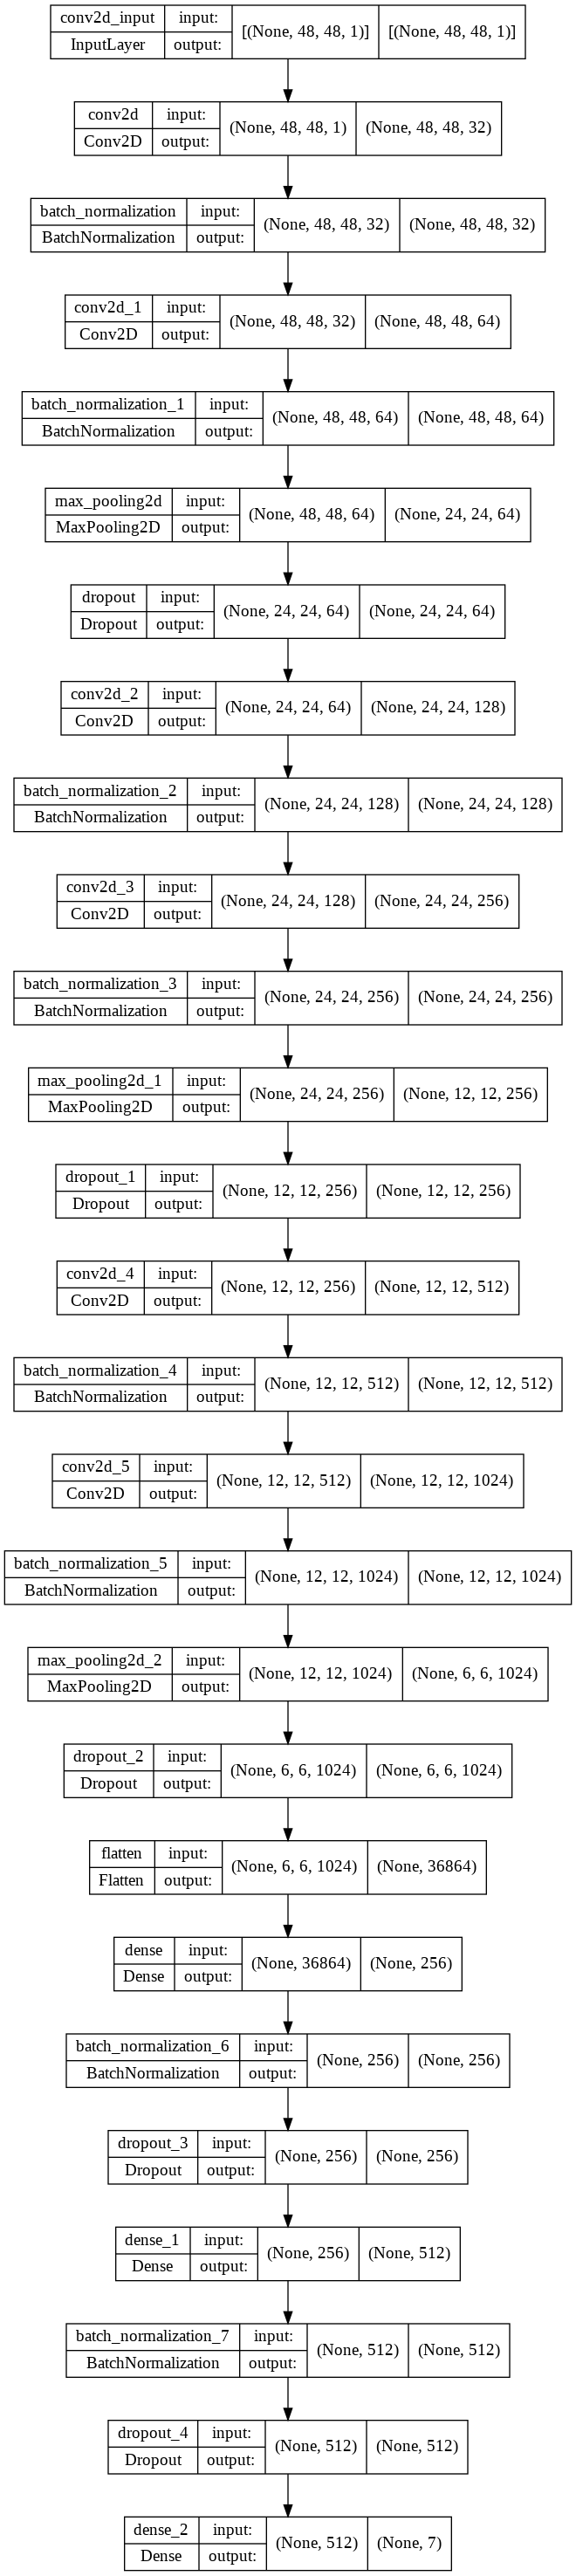

In [ ]:
plot_model(model_1, show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 50

path_to_save_model = "/content/fer/my_cnn_la.h5" # dropout 0.2 hali

ckpnt_saver = ModelCheckpoint(
    filepath = path_to_save_model,
    monitor = "val_accuracy",
    mode="max",
    save_best_only = True,
    save_freq = "epoch",
    verbose=1
    )

model_1.compile(optimizer = "Adam",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"]
              )

history_1 = model_1.fit(train_generator, 
          epochs = epochs,
          batch_size = batch_size,
          validation_data = val_generator,
          callbacks = [ckpnt_saver]
          )

Epoch 1/50
359/359 [==============================] - ETA: 0s - loss: 2.0835 - accuracy: 0.2406
Epoch 1: val_accuracy improved from -inf to 0.20066, saving model to /content/fer/my_cnn_la.h5
359/359 [==============================] - 47s 89ms/step - loss: 2.0835 - accuracy: 0.2406 - val_loss: 1.9596 - val_accuracy: 0.2007
Epoch 2/50
359/359 [==============================] - ETA: 0s - loss: 1.7164 - accuracy: 0.3428
Epoch 2: val_accuracy improved from 0.20066 to 0.34994, saving model to /content/fer/my_cnn_la.h5
359/359 [==============================] - 29s 82ms/step - loss: 1.7164 - accuracy: 0.3428 - val_loss: 1.7547 - val_accuracy: 0.3499
Epoch 3/50
359/359 [==============================] - ETA: 0s - loss: 1.5023 - accuracy: 0.4220
Epoch 3: val_accuracy improved from 0.34994 to 0.42902, saving model to /content/fer/my_cnn_la.h5
359/359 [==============================] - 29s 80ms/step - loss: 1.5023 - accuracy: 0.4220 - val_loss: 1.5180 - val_accuracy: 0.4290
Epoch 4/50
359/359 [==

In [ ]:
print(history_1.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
def show_acc_and_loss(model):    
    plt.figure(figsize=(14,6))

    train_acc = model.history["accuracy"]
    train_loss = model.history["loss"]

    plt.subplot(1,2,1)
    plt.plot(model.history["accuracy"])
    plt.plot(model.history["val_accuracy"])
    plt.title("Train and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Validation"])

    plt.subplot(1,2,2)
    plt.plot(model.history["loss"])
    plt.plot(model.history["val_loss"])
    plt.title("Train and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Train", "Validation"])

    plt.show()

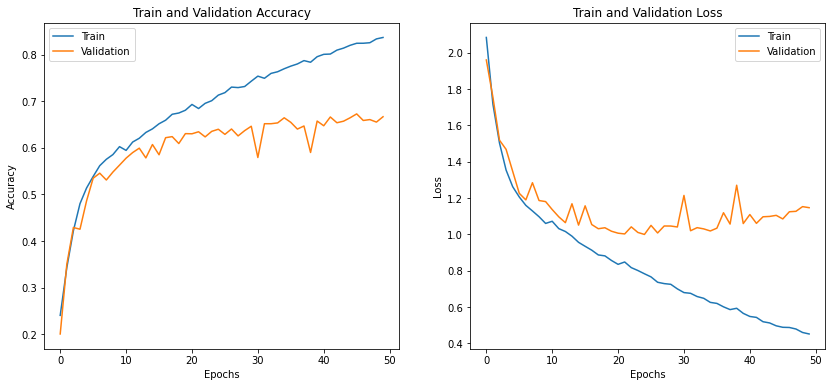

In [ ]:
show_acc_and_loss(history_1)

In [ ]:
model = tf.keras.models.load_model("/content/fer/my_cnn_la.h5")

print("Evaluating train set: ")
model.evaluate(train_generator)

print("Evaluating test set: ")
model.evaluate(test_generator)

Evaluating train set: 
359/359 [==============================] - 17s 47ms/step - loss: 0.3057 - accuracy: 0.8937
Evaluating test set: 
113/113 [==============================] - 6s 53ms/step - loss: 1.0869 - accuracy: 0.6695


[1.0868511199951172, 0.6695458292961121]

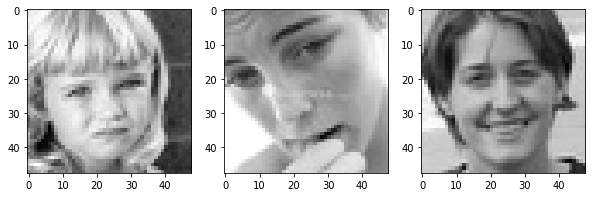

In [ ]:
test_img_1 = image.load_img("/content/fer/test/sad/PrivateTest_2552088.jpg", target_size = (48,48), color_mode = "grayscale")
test_img_2 = image.load_img("/content/fer/test/fear/PrivateTest_3463701.jpg", target_size = (48,48), color_mode = "grayscale")
test_img_3 = image.load_img("/content/fer/test/happy/PrivateTest_3579299.jpg", target_size = (48,48), color_mode = "grayscale")

plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
plt.imshow(test_img_1, cmap="gray")
plt.subplot(1,3,2)
plt.imshow(test_img_2, cmap="gray")
plt.subplot(1,3,3)
plt.imshow(test_img_3, cmap="gray")

In [ ]:
def prediction_on_test_image(model, test_img):   
    dictionary = train_generator.class_indices

    test_img = np.expand_dims(test_img, axis=0)
    test_img = test_img.reshape(1,48,48,1)
    result = model.predict(test_img)
    result = list(result[0])
    #print(result)

    img_index = result.index(max(result))

    key = [key for key,value in dictionary.items() if value==img_index]
    
    return key[0]

In [ ]:
prediction_on_test_image(model, test_img_1)

'angry'

In [ ]:
prediction_on_test_image(model, test_img_2)

'sad'

In [ ]:
prediction_on_test_image(model, test_img_3)

'happy'

TRAIN


<Figure size 720x1152 with 0 Axes>

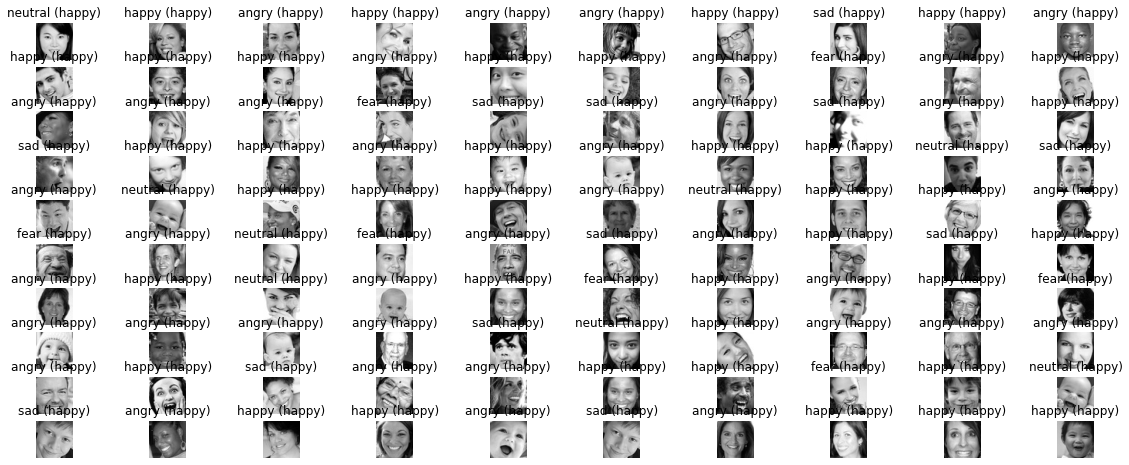

In [ ]:
# Veri setinden bazı örneklere bakalım.
def plot_test_images(class_name, test_data_path, model):
    plt.figure(figsize=(10,16))
    
    class_labels = test_generator.class_indices
    figure = plt.figure(figsize=(20, 8))

    i=10
    j=10

    image_size=(48,48)

    for exp in os.listdir(test_data_path):
        if exp == class_name:
            full_path = os.path.join(test_data_path, class_name)
            images_path = glob.glob(os.path.join(full_path, '*.jpg'))
            for k in range(100):
                random_image_name = random.choice(images_path)
                #print(random_image_name)
                
                lst=[]
                c="\\"
                count=1
                i=1
                for pos,char in enumerate(random_image_name):
                    if(char == c and count==1):
                        random_image_name = random_image_name[:pos] + '\\' + random_image_name[pos:]
                        count+=1
                        #print(random_image_name)    
                    elif(char == c):
                        pos+=i
                        i+=1
                        random_image_name = random_image_name[:pos] + '\\' + random_image_name[pos:]
                        #print(random_image_name)
                        
                #print(random_image_name)

                img = image.load_img(random_image_name, target_size=(48,48), color_mode="grayscale")
                
                predict_class = prediction_on_test_image(model, img)
                
                true_index = class_name
                
                ax = figure.add_subplot(10, 10, k+1)
                ax.set_title("{} ({})".format((predict_class), (true_index)))
                plt.imshow(img, cmap="gray")
                plt.axis("off")
                
print("TRAIN")
plot_test_images("happy", test_data_path, model);

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


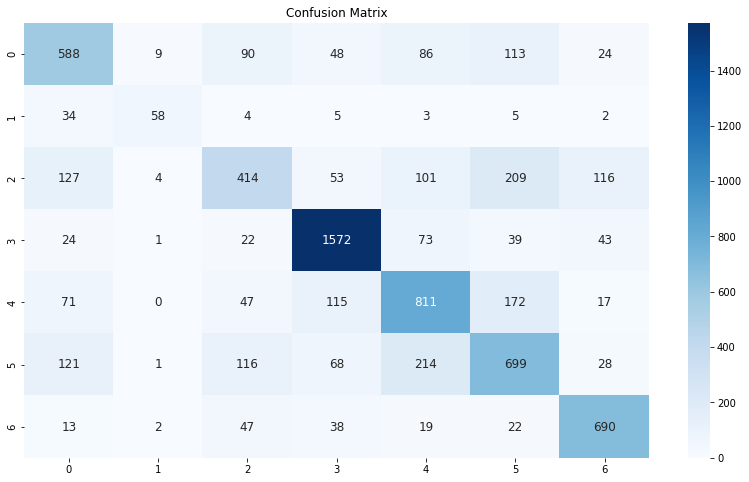

In [ ]:
from sklearn.metrics import confusion_matrix

print(test_generator.class_indices)

y_pred = model.predict(test_generator)
pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(test_generator.classes, pred)
plt.figure(figsize = (14,8))
plt.title("Confusion Matrix")

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 12})

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

emotion_dict = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}

print('Classification Report')

print(classification_report(test_generator.classes, pred, target_names = emotion_dict.keys()))

Classification Report
              precision    recall  f1-score   support

       angry       0.60      0.61      0.61       958
     disgust       0.77      0.52      0.62       111
        fear       0.56      0.40      0.47      1024
       happy       0.83      0.89      0.86      1774
     neutral       0.62      0.66      0.64      1233
         sad       0.56      0.56      0.56      1247
    surprise       0.75      0.83      0.79       831

    accuracy                           0.67      7178
   macro avg       0.67      0.64      0.65      7178
weighted avg       0.67      0.67      0.67      7178

